In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sin
from math import pi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
from keras.optimizers import RMSprop

In [155]:
warnings.simplefilter('ignore')

Считываем данные и посмотрим на них

In [156]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

In [157]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [158]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [159]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [160]:
aggregation = {
    'ACTUAL': 'sum',
    'PROMO': 'max',
    'YEAR': 'max',
    'MONTH': 'max',
    'DAY': 'max'
}

In [161]:
def sin_day(val):
    return sin(val*(2*pi)/31)

In [162]:
def sin_month(val):
    return sin(val*(2*pi)/12)

Выберем определенный opstudy (например 51) и будем с ним работать

In [163]:
opst_51 = data[data['OPSTUDY']==51].copy()

Удалим в новом датасете столбцы 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', так как мы уже определились с opstudy; колонку 'SEG' удалим, так как она не очень информативна; также удалим все остальные описательные характеристики продуктов 

In [164]:
opst_51.drop(['PLN_LABEL', 'PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', 'SEG'], axis=1, inplace=True)

Преобразуем наши данные в необходимые типы, а также приведем колонку 'WEEK' в нужный строковый тип при помощи функции date_divide, чтобы потом привести в дату

In [165]:
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: str(x))
opst_51['PLN'] = opst_51['PLN'].apply(lambda x: str(x))
opst_51['ACTUAL'] = opst_51['ACTUAL'].apply(lambda x: float(x))
opst_51['PROMO'] = opst_51['PROMO'].apply(lambda x: str(x))
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: date_divide(x))

Приводим 'WEEK' в дату и создаем еще три колонки: год, месяц и день (неделю)

In [166]:
opst_51['WEEK'] = pd.to_datetime(opst_51['WEEK'])
opst_51['YEAR'] = [d.year for d in opst_51['WEEK']]
opst_51['MONTH'] = [d.month for d in opst_51['WEEK']]
opst_51['DAY'] = [d.day for d in opst_51['WEEK']]

Создаем словарь и заменяем колонку 'PROMO' на числовые значения; кроме того в колонке часто встречаются пропуски, это связано с тем, что в наших данных встречаются для одних и тех же pln повторяющиеся недели. В таких случаях одно из значений будет 0 или 1 а другие nan. Заменим пока все nan на 0, а затем при агрегации будем брать максимум (если хотя бы в одной недели была 1, то значит 'PROMO' принимает значение 1)

In [167]:
promo_dict = {'N':0, 'Y':1}
opst_51['PROMO'] = opst_51['PROMO'].replace(promo_dict)
opst_51['PROMO'] = opst_51['PROMO'].replace({'nan':0})

Проведем агрегацию данных по дате и pln

In [168]:
opst_51 = opst_51.groupby(['WEEK', 'PLN'], as_index=False).agg(aggregation)

Возьмем первый попавшийся pln и сделаем отдельно для него прогноз

In [169]:
first_pln = opst_51[opst_51['PLN']=='40000131497'].copy()

In [170]:
first_pln.drop('PLN', axis=1, inplace=True)

Введем новый признак - среднее значение продаж по каждому месяцу

In [171]:
first_pln['YEAR_MONTH'] = [str(d.year) + '/' + str(d.month) for d in first_pln['WEEK']]
year_month = np.unique(first_pln['YEAR_MONTH'].values)
ym_mean = np.array([first_pln[first_pln['YEAR_MONTH']==d]['ACTUAL'].mean() for d in year_month])
mean_dict = dict(zip(year_month, ym_mean))
first_pln['MEAN_PER_MONTH'] = first_pln['YEAR_MONTH'].replace(mean_dict)

Значения данных в зависимости от признака сильно разнятся, поэтому нормализируем наши данные о продажах и среднее по месяцам

In [172]:
scaler = MinMaxScaler()
scaler.fit(np.array(first_pln['ACTUAL']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['ACTUAL']).reshape(-1, 1))
first_pln['ACTUAL'] = norm_act.ravel()

In [173]:
scaler.fit(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
first_pln['MEAN_PER_MONTH'] = norm_act.ravel()

Приведем также признаки месяц и день к синусу и косинусу, располагая дни\месяца на тригонометрической окружности; признак 'YEAR' удалим

In [174]:
first_pln.reset_index(inplace=True)
first_pln.set_index('WEEK', inplace=True)
first_pln.drop(['YEAR_MONTH', 'YEAR'], axis=1, inplace=True)
first_pln['MONTH'] = first_pln['MONTH'].apply(lambda m: sin_month(m))
first_pln['DAY'] = first_pln['DAY'].apply(lambda d: sin_day(d))
first_pln.reset_index('WEEK', inplace=True)
first_pln.drop('index', axis=1, inplace=True)

Взглянем на получившиеся данные

In [175]:
first_pln.head()

,WEEK,ACTUAL,PROMO,MONTH,DAY,MEAN_PER_MONTH
0,2015-02-08,0.046961,0,0.866025,0.998717,0.037634
1,2015-02-15,0.039595,0,0.866025,0.101168,0.037634
2,2015-02-22,0.039595,0,0.866025,-0.968077,0.037634
3,2015-03-01,0.033149,0,1.000000,0.201299,0.083073
4,2015-03-08,0.067219,0,1.000000,0.998717,0.083073


Построим графики продаж и среднего за месяц

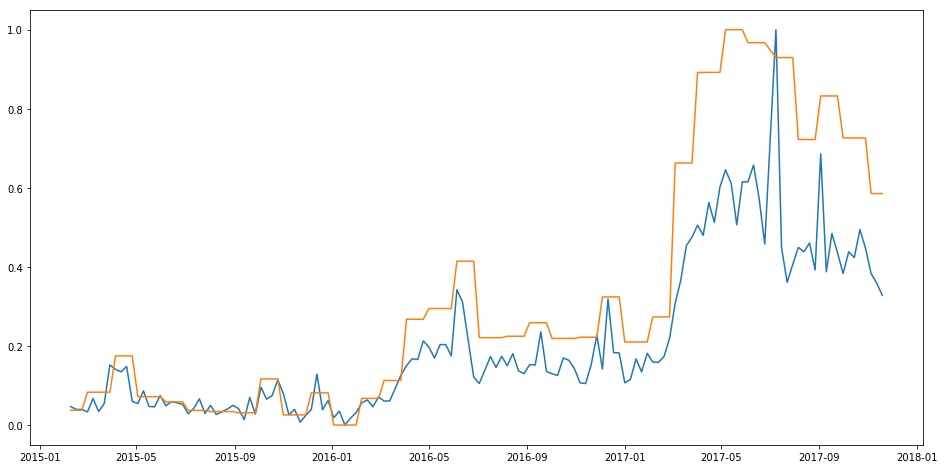

In [176]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['ACTUAL'])
plt.plot(first_pln['WEEK'], first_pln['MEAN_PER_MONTH'])
plt.show()

Графики дней и месяцев

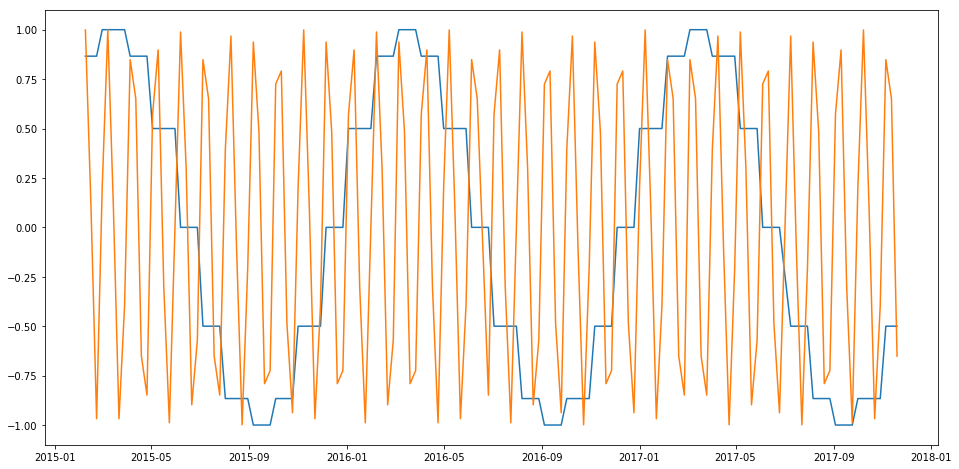

In [177]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH'])
plt.plot(first_pln['WEEK'], first_pln['DAY'])
plt.show()

Поставим целевой признак в конец датасета

In [178]:
act = first_pln['ACTUAL']
first_pln.drop('ACTUAL', axis=1, inplace = True)
first_pln.insert(5, 'ACTUAL', act)

In [179]:
first_pln['WEEK'] = first_pln['WEEK'].apply(lambda x: str(x))

In [180]:
first_pln.set_index('WEEK', inplace=True)

In [181]:
first_pln.head()

,PROMO,MONTH,DAY,MEAN_PER_MONTH,ACTUAL
WEEK,,,,,
2015-02-08 00:00:00,0,0.866025,0.998717,0.037634,0.046961
2015-02-15 00:00:00,0,0.866025,0.101168,0.037634,0.039595
2015-02-22 00:00:00,0,0.866025,-0.968077,0.037634,0.039595
2015-03-01 00:00:00,0,1.000000,0.201299,0.083073,0.033149
2015-03-08 00:00:00,0,1.000000,0.998717,0.083073,0.067219


Преобразуем еще немного наши данные, а именно измених их размерности (для того, чтобы скормить их нашей сети необходимо привести их к трехмерным тензорам); помимо этого разделим наш набор на тестовую и обучающую выборки

In [182]:
lstm_data = first_pln.values

In [183]:
train = lstm_data[:100, :]
test = lstm_data[100:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 1, 4) (100,) (44, 1, 4) (44,)


Входным слоем нашей сети будет lstm слой, оптимизатор - RMSprop, для оценки ошибки возьмем среднюю абсолютную ошибку, в качестве валидационных данных возьмем тестовую выборку

In [184]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=RMSprop())
history = model.fit(X_train, y_train, epochs=700, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 100 samples, validate on 44 samples
Epoch 1/700
 - 1s - loss: 0.1056 - val_loss: 0.4160
Epoch 2/700
 - 0s - loss: 0.0857 - val_loss: 0.3962
Epoch 3/700
 - 0s - loss: 0.0741 - val_loss: 0.3802
Epoch 4/700
 - 0s - loss: 0.0661 - val_loss: 0.3664
Epoch 5/700
 - 0s - loss: 0.0600 - val_loss: 0.3540
Epoch 6/700
 - 0s - loss: 0.0564 - val_loss: 0.3441
Epoch 7/700
 - 0s - loss: 0.0539 - val_loss: 0.3345
Epoch 8/700
 - 0s - loss: 0.0521 - val_loss: 0.3261
Epoch 9/700
 - 0s - loss: 0.0512 - val_loss: 0.3185
Epoch 10/700
 - 0s - loss: 0.0504 - val_loss: 0.3110
Epoch 11/700
 - 0s - loss: 0.0497 - val_loss: 0.3036
Epoch 12/700
 - 0s - loss: 0.0490 - val_loss: 0.2966
Epoch 13/700
 - 0s - loss: 0.0486 - val_loss: 0.2907
Epoch 14/700
 - 0s - loss: 0.0484 - val_loss: 0.2853
Epoch 15/700
 - 0s - loss: 0.0483 - val_loss: 0.2798
Epoch 16/700
 - 0s - loss: 0.0484 - val_loss: 0.2754
Epoch 17/700
 - 0s - loss: 0.0484 - val_loss: 0.2715
Epoch 18/700
 - 0s - loss: 0.0484 - val_loss: 0.2701
Epoch 19/7

Epoch 154/700
 - 0s - loss: 0.0206 - val_loss: 0.0626
Epoch 155/700
 - 0s - loss: 0.0211 - val_loss: 0.0643
Epoch 156/700
 - 0s - loss: 0.0211 - val_loss: 0.0629
Epoch 157/700
 - 0s - loss: 0.0209 - val_loss: 0.0640
Epoch 158/700
 - 0s - loss: 0.0207 - val_loss: 0.0627
Epoch 159/700
 - 0s - loss: 0.0211 - val_loss: 0.0643
Epoch 160/700
 - 0s - loss: 0.0210 - val_loss: 0.0630
Epoch 161/700
 - 0s - loss: 0.0208 - val_loss: 0.0646
Epoch 162/700
 - 0s - loss: 0.0210 - val_loss: 0.0628
Epoch 163/700
 - 0s - loss: 0.0211 - val_loss: 0.0643
Epoch 164/700
 - 0s - loss: 0.0209 - val_loss: 0.0631
Epoch 165/700
 - 0s - loss: 0.0210 - val_loss: 0.0643
Epoch 166/700
 - 0s - loss: 0.0210 - val_loss: 0.0631
Epoch 167/700
 - 0s - loss: 0.0208 - val_loss: 0.0644
Epoch 168/700
 - 0s - loss: 0.0209 - val_loss: 0.0628
Epoch 169/700
 - 0s - loss: 0.0209 - val_loss: 0.0644
Epoch 170/700
 - 0s - loss: 0.0210 - val_loss: 0.0630
Epoch 171/700
 - 0s - loss: 0.0211 - val_loss: 0.0643
Epoch 172/700
 - 0s - loss: 

Epoch 306/700
 - 0s - loss: 0.0206 - val_loss: 0.0654
Epoch 307/700
 - 0s - loss: 0.0205 - val_loss: 0.0661
Epoch 308/700
 - 0s - loss: 0.0207 - val_loss: 0.0664
Epoch 309/700
 - 0s - loss: 0.0207 - val_loss: 0.0651
Epoch 310/700
 - 0s - loss: 0.0204 - val_loss: 0.0665
Epoch 311/700
 - 0s - loss: 0.0208 - val_loss: 0.0656
Epoch 312/700
 - 0s - loss: 0.0204 - val_loss: 0.0661
Epoch 313/700
 - 0s - loss: 0.0208 - val_loss: 0.0663
Epoch 314/700
 - 0s - loss: 0.0206 - val_loss: 0.0661
Epoch 315/700
 - 0s - loss: 0.0209 - val_loss: 0.0664
Epoch 316/700
 - 0s - loss: 0.0206 - val_loss: 0.0661
Epoch 317/700
 - 0s - loss: 0.0204 - val_loss: 0.0663
Epoch 318/700
 - 0s - loss: 0.0208 - val_loss: 0.0656
Epoch 319/700
 - 0s - loss: 0.0203 - val_loss: 0.0661
Epoch 320/700
 - 0s - loss: 0.0207 - val_loss: 0.0666
Epoch 321/700
 - 0s - loss: 0.0207 - val_loss: 0.0655
Epoch 322/700
 - 0s - loss: 0.0203 - val_loss: 0.0665
Epoch 323/700
 - 0s - loss: 0.0208 - val_loss: 0.0664
Epoch 324/700
 - 0s - loss: 

Epoch 458/700
 - 0s - loss: 0.0204 - val_loss: 0.0688
Epoch 459/700
 - 0s - loss: 0.0209 - val_loss: 0.0688
Epoch 460/700
 - 0s - loss: 0.0205 - val_loss: 0.0680
Epoch 461/700
 - 0s - loss: 0.0203 - val_loss: 0.0682
Epoch 462/700
 - 0s - loss: 0.0202 - val_loss: 0.0687
Epoch 463/700
 - 0s - loss: 0.0207 - val_loss: 0.0686
Epoch 464/700
 - 0s - loss: 0.0208 - val_loss: 0.0684
Epoch 465/700
 - 0s - loss: 0.0203 - val_loss: 0.0686
Epoch 466/700
 - 0s - loss: 0.0206 - val_loss: 0.0688
Epoch 467/700
 - 0s - loss: 0.0208 - val_loss: 0.0683
Epoch 468/700
 - 0s - loss: 0.0203 - val_loss: 0.0683
Epoch 469/700
 - 0s - loss: 0.0203 - val_loss: 0.0685
Epoch 470/700
 - 0s - loss: 0.0208 - val_loss: 0.0685
Epoch 471/700
 - 0s - loss: 0.0204 - val_loss: 0.0690
Epoch 472/700
 - 0s - loss: 0.0210 - val_loss: 0.0689
Epoch 473/700
 - 0s - loss: 0.0205 - val_loss: 0.0684
Epoch 474/700
 - 0s - loss: 0.0205 - val_loss: 0.0692
Epoch 475/700
 - 0s - loss: 0.0209 - val_loss: 0.0681
Epoch 476/700
 - 0s - loss: 

Epoch 610/700
 - 0s - loss: 0.0206 - val_loss: 0.0694
Epoch 611/700
 - 0s - loss: 0.0203 - val_loss: 0.0710
Epoch 612/700
 - 0s - loss: 0.0208 - val_loss: 0.0706
Epoch 613/700
 - 0s - loss: 0.0206 - val_loss: 0.0696
Epoch 614/700
 - 0s - loss: 0.0203 - val_loss: 0.0701
Epoch 615/700
 - 0s - loss: 0.0201 - val_loss: 0.0701
Epoch 616/700
 - 0s - loss: 0.0208 - val_loss: 0.0697
Epoch 617/700
 - 0s - loss: 0.0202 - val_loss: 0.0702
Epoch 618/700
 - 0s - loss: 0.0206 - val_loss: 0.0699
Epoch 619/700
 - 0s - loss: 0.0201 - val_loss: 0.0701
Epoch 620/700
 - 0s - loss: 0.0206 - val_loss: 0.0702
Epoch 621/700
 - 0s - loss: 0.0202 - val_loss: 0.0709
Epoch 622/700
 - 0s - loss: 0.0209 - val_loss: 0.0705
Epoch 623/700
 - 0s - loss: 0.0204 - val_loss: 0.0699
Epoch 624/700
 - 0s - loss: 0.0201 - val_loss: 0.0706
Epoch 625/700
 - 0s - loss: 0.0205 - val_loss: 0.0700
Epoch 626/700
 - 0s - loss: 0.0204 - val_loss: 0.0697
Epoch 627/700
 - 0s - loss: 0.0200 - val_loss: 0.0709
Epoch 628/700
 - 0s - loss: 

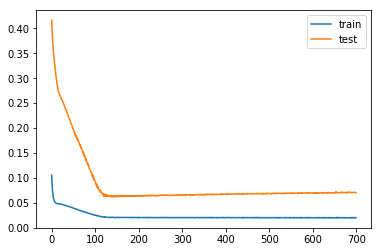

In [185]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Найдем прогноз и посчитаем среднеквадратичную ошибку

In [186]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 67.502


Графики предсказания и тестовой выборки

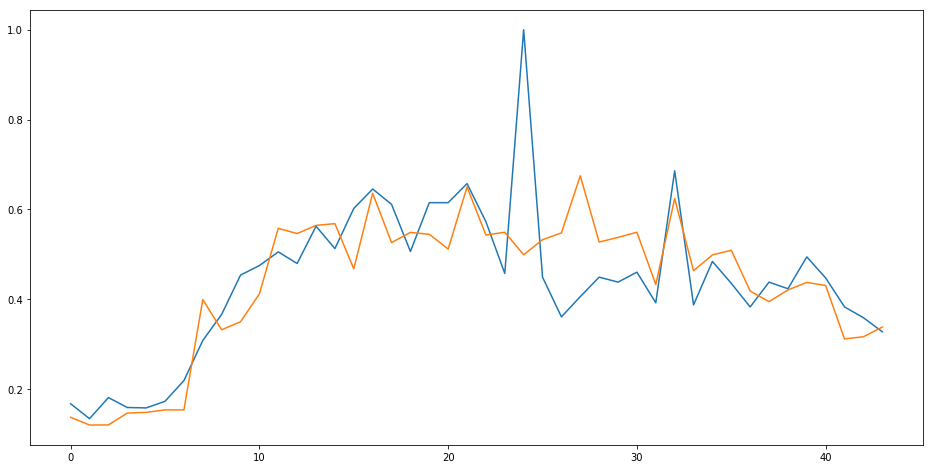

In [187]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()

Возьмем какой-нибудь новый pln и построим для него другую сеть

In [188]:
second_pln = opst_51[opst_51['PLN']=='40000131505'].copy()

In [189]:
second_pln.drop('PLN', axis=1, inplace=True)

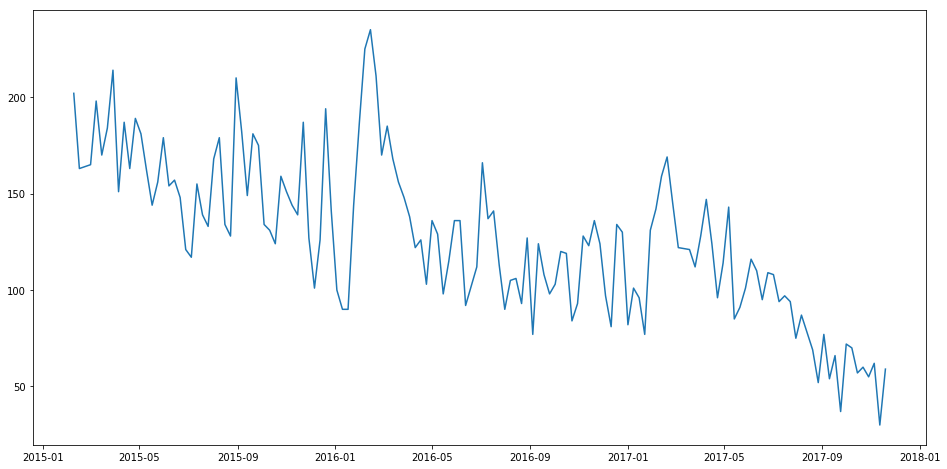

In [190]:
plt.figure(figsize=(16,8))
plt.plot(second_pln['WEEK'], second_pln['ACTUAL'])
plt.show()

In [191]:
second_pln

,WEEK,ACTUAL,PROMO,YEAR,MONTH,DAY
1,2015-02-08,202.0,0,2015,2,8
629,2015-02-15,163.0,0,2015,2,15
1257,2015-02-22,164.0,0,2015,2,22
1885,2015-03-01,165.0,0,2015,3,1
2511,2015-03-08,198.0,0,2015,3,8
3137,2015-03-15,170.0,0,2015,3,15
3758,2015-03-22,184.0,0,2015,3,22
4379,2015-03-29,214.0,0,2015,3,29
5000,2015-04-05,151.0,0,2015,4,5
5621,2015-04-12,187.0,0,2015,4,12


Поступим теперь иначе: а именно удалим все признаки кроме 'ACTUAL'. Тренировочный набор будет представлять данные по сути только за 2016 год и состоять из целевого признака - 'ACTUAL' и трех признаков - продажи соответственно в эту же неделю, но только за 2015 год и значения продаж 2 недель ранее в 2015 году; также добавим среднее значение продаж по этим трем неделям. Аналогично будет выглядеть тестовая выборка, но для 2016-2017 года (предсказания соответственно на 2017)

Так как наши данные начинаются с 2015-02-08, а заканчиваются на 2017-11-19, к тому же, учитывая тот факт, что мы берем еще предыдущие две недели, то будем делать предсказания только с марта по ноябрь

In [192]:
second_pln.set_index('WEEK', inplace=True)

In [279]:
df15 = second_pln[second_pln['YEAR']==2015].copy()

In [280]:
df15.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [281]:
df16 = second_pln[second_pln['YEAR']==2016].copy()

In [282]:
df16.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [283]:
df17 = second_pln[second_pln['YEAR']==2017].copy()

In [284]:
df17.drop(['YEAR', 'PROMO'], axis=1, inplace=True)

In [285]:
print(len(df15))
print(len(df16))
print(len(df17))

47
51
46


In [286]:
df15.head()

,ACTUAL,MONTH,DAY
WEEK,,,
2015-02-08,202.0,2,8
2015-02-15,163.0,2,15
2015-02-22,164.0,2,22
2015-03-01,165.0,3,1
2015-03-08,198.0,3,8


In [287]:
df15 = df15.ix[(df15['MONTH']!=1) & (df15['MONTH']!=2) & (df15['MONTH']!=12)]

In [288]:
df16 = df16.ix[(df16['MONTH']!=1) & (df16['MONTH']!=2) & (df16['MONTH']!=12)]

In [289]:
df17 = df17.ix[(df17['MONTH']!=1) & (df17['MONTH']!=2) & (df17['MONTH']!=12)]

In [290]:
print(len(df15))
print(len(df16))
print(len(df17))

40
38
37


In [291]:
df17

,ACTUAL,MONTH,DAY
WEEK,,,
2017-03-05,122.0,3,5
2017-03-19,121.0,3,19
2017-03-26,112.0,3,26
2017-04-02,128.0,4,2
2017-04-09,147.0,4,9
2017-04-16,124.0,4,16
2017-04-23,96.0,4,23
2017-04-30,114.0,4,30
2017-05-07,143.0,5,7


In [292]:
df16

,ACTUAL,MONTH,DAY
WEEK,,,
2016-03-06,185.0,3,6
2016-03-13,168.0,3,13
2016-03-20,156.0,3,20
2016-03-27,148.0,3,27
2016-04-03,138.0,4,3
2016-04-10,122.0,4,10
2016-04-17,126.0,4,17
2016-04-24,103.0,4,24
2016-05-01,136.0,5,1


In [293]:
df16.drop(df16.tail(1).index, inplace=True)

In [294]:
df15

,ACTUAL,MONTH,DAY
WEEK,,,
2015-03-01,165.0,3,1
2015-03-08,198.0,3,8
2015-03-15,170.0,3,15
2015-03-22,184.0,3,22
2015-03-29,214.0,3,29
2015-04-05,151.0,4,5
2015-04-12,187.0,4,12
2015-04-19,163.0,4,19
2015-04-26,189.0,4,26


In [295]:
df15.drop(df15.tail(2).index, inplace=True)
df15.drop(df15.head(1).index, inplace=True)

In [296]:
print(len(df15))
print(len(df16))
print(len(df17))

37
37
37


In [297]:
df15.drop(['MONTH', 'DAY'], axis=1, inplace=True)
df16.drop(['MONTH', 'DAY'], axis=1, inplace=True)
df17.drop(['MONTH', 'DAY'], axis=1, inplace=True)

In [298]:
df16['FIRST'] = df15['ACTUAL'].values

In [299]:
second = np.array([])
second = np.append(second, second_pln.loc['2015-03-01']['ACTUAL'])
second = np.append(second, df15.head(len(df15)-1)['ACTUAL'].values)

In [300]:
df16['SECOND'] = second

In [301]:
third = np.array([])
third = np.append(third, second_pln.loc['2015-02-22']['ACTUAL'])
third = np.append(third, second_pln.loc['2015-03-01']['ACTUAL'])
third = np.append(third, df15.head(len(df15)-2)['ACTUAL'].values)

In [302]:
df16['THIRD'] = third

In [303]:
df17['FIRST'] = df16['ACTUAL'].values

In [304]:
second = np.array([])
second = np.append(second, second_pln.loc['2016-02-28']['ACTUAL'])
second = np.append(second, df16.head(len(df16)-1)['ACTUAL'].values)

In [305]:
df17['SECOND'] = second

In [306]:
third = np.array([])
third = np.append(third, second_pln.loc['2016-02-21']['ACTUAL'])
third = np.append(third, second_pln.loc['2016-02-28']['ACTUAL'])
third = np.append(third, df16.head(len(df16)-2)['ACTUAL'].values)

In [307]:
df17['THIRD'] = third

In [308]:
df16['MEAN'] = df16.loc[: , 'FIRST':'THIRD'].mean(axis=1)

In [309]:
df17['MEAN'] = df17.loc[: , 'FIRST':'THIRD'].mean(axis=1)

In [310]:
act = df16['ACTUAL']
df16.drop('ACTUAL', axis=1, inplace = True)
df16.insert(4, 'ACTUAL', act)

In [311]:
act = df17['ACTUAL']
df17.drop('ACTUAL', axis=1, inplace = True)
df17.insert(4, 'ACTUAL', act)

In [327]:
train = df16.values
test = df17.values
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37, 1, 4) (37,) (37, 1, 4) (37,)


In [328]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
model.fit(X_train, y_train, epochs=400)

Epoch 1/400
37/37 [==============================] - 3s 82ms/step - loss: 121.4415
Epoch 2/400
37/37 [==============================] - 0s 310us/step - loss: 121.2039
Epoch 3/400
37/37 [==============================] - 0s 337us/step - loss: 121.0167
Epoch 4/400
37/37 [==============================] - 0s 364us/step - loss: 120.8901
Epoch 5/400
37/37 [==============================] - 0s 324us/step - loss: 120.8975
Epoch 6/400
37/37 [==============================] - 0s 351us/step - loss: 120.7084
Epoch 7/400
37/37 [==============================] - 0s 432us/step - loss: 120.5736
Epoch 8/400
37/37 [==============================] - 0s 512us/step - loss: 120.5117
Epoch 9/400
37/37 [==============================] - 0s 674us/step - loss: 120.4597
Epoch 10/400
37/37 [==============================] - ETA: 0s - loss: 121.416 - 0s 526us/step - loss: 120.3477
Epoch 11/400
37/37 [==============================] - 0s 593us/step - loss: 120.2325
Epoch 12/400
37/37 [=============================

37/37 [==============================] - 0s 351us/step - loss: 109.7834
Epoch 97/400
37/37 [==============================] - 0s 310us/step - loss: 109.9288
Epoch 98/400
37/37 [==============================] - 0s 351us/step - loss: 109.6951
Epoch 99/400
37/37 [==============================] - 0s 405us/step - loss: 109.4479
Epoch 100/400
37/37 [==============================] - 0s 472us/step - loss: 109.4802
Epoch 101/400
37/37 [==============================] - 0s 364us/step - loss: 109.7288
Epoch 102/400
37/37 [==============================] - 0s 432us/step - loss: 109.6000
Epoch 103/400
37/37 [==============================] - 0s 297us/step - loss: 109.3929
Epoch 104/400
37/37 [==============================] - 0s 310us/step - loss: 109.3014
Epoch 105/400
37/37 [==============================] - 0s 486us/step - loss: 109.1818
Epoch 106/400
37/37 [==============================] - 0s 432us/step - loss: 108.9307
Epoch 107/400
37/37 [==============================] - 0s 512us/step - 

37/37 [==============================] - 0s 634us/step - loss: 103.2227
Epoch 191/400
37/37 [==============================] - 0s 472us/step - loss: 103.0661
Epoch 192/400
37/37 [==============================] - 0s 607us/step - loss: 102.9859
Epoch 193/400
37/37 [==============================] - 0s 472us/step - loss: 102.9158
Epoch 194/400
37/37 [==============================] - 0s 580us/step - loss: 102.8254
Epoch 195/400
37/37 [==============================] - 0s 620us/step - loss: 102.9021
Epoch 196/400
37/37 [==============================] - 0s 674us/step - loss: 102.8191
Epoch 197/400
37/37 [==============================] - 0s 998us/step - loss: 102.6303
Epoch 198/400
37/37 [==============================] - 0s 405us/step - loss: 102.5664
Epoch 199/400
37/37 [==============================] - 0s 418us/step - loss: 102.5438
Epoch 200/400
37/37 [==============================] - 0s 310us/step - loss: 102.4648
Epoch 201/400
37/37 [==============================] - 0s 351us/step

37/37 [==============================] - 0s 351us/step - loss: 96.8069
Epoch 286/400
37/37 [==============================] - 0s 297us/step - loss: 96.7426
Epoch 287/400
37/37 [==============================] - 0s 351us/step - loss: 96.6749
Epoch 288/400
37/37 [==============================] - 0s 351us/step - loss: 96.6548
Epoch 289/400
37/37 [==============================] - 0s 364us/step - loss: 96.5429
Epoch 290/400
37/37 [==============================] - 0s 391us/step - loss: 96.8581
Epoch 291/400
37/37 [==============================] - 0s 364us/step - loss: 96.4117
Epoch 292/400
37/37 [==============================] - 0s 378us/step - loss: 96.3645
Epoch 293/400
37/37 [==============================] - 0s 324us/step - loss: 96.2791
Epoch 294/400
37/37 [==============================] - 0s 351us/step - loss: 96.2200
Epoch 295/400
37/37 [==============================] - 0s 310us/step - loss: 96.1493
Epoch 296/400
37/37 [==============================] - 0s 364us/step - loss: 96

37/37 [==============================] - 0s 432us/step - loss: 90.4698
Epoch 382/400
37/37 [==============================] - 0s 513us/step - loss: 90.4038
Epoch 383/400
37/37 [==============================] - 0s 391us/step - loss: 90.3383
Epoch 384/400
37/37 [==============================] - 0s 337us/step - loss: 90.6582
Epoch 385/400
37/37 [==============================] - 0s 351us/step - loss: 90.2083
Epoch 386/400
37/37 [==============================] - 0s 486us/step - loss: 90.1418
Epoch 387/400
37/37 [==============================] - 0s 499us/step - loss: 90.0878
Epoch 388/400
37/37 [==============================] - 0s 486us/step - loss: 90.0091
Epoch 389/400
37/37 [==============================] - 0s 432us/step - loss: 90.3466
Epoch 390/400
37/37 [==============================] - 0s 634us/step - loss: 89.8925
Epoch 391/400
37/37 [==============================] - 0s 661us/step - loss: 89.8109
Epoch 392/400
37/37 [==============================] - 0s 432us/step - loss: 89

In [314]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 38685.547


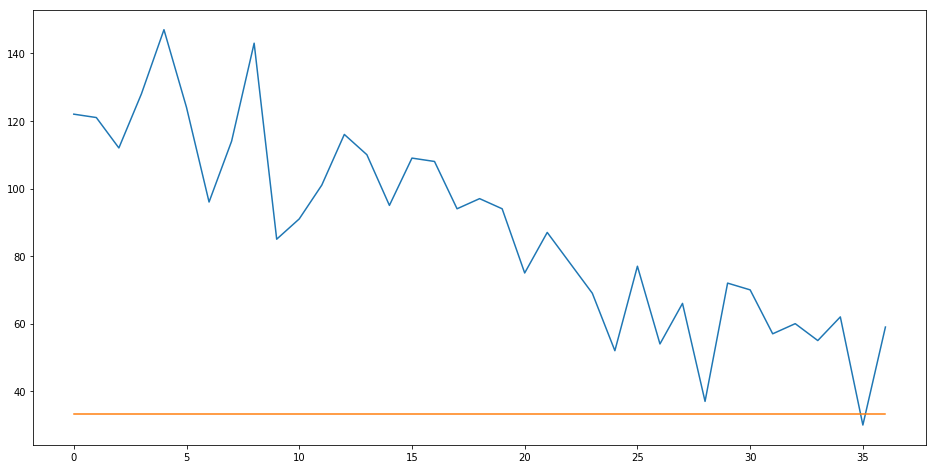

In [316]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()

Что-то тут не так